<a href="https://colab.research.google.com/github/charlie-perez-35/DS-2002-002/blob/main/tripleexpsmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

filepath = r'/content/seaice_data.csv'
seaice = pd.read_csv(filepath)
seaice.head()

,Extent_north,Datetime,Extent_south,Extent_total
0,10.231,1978-10-26,17.624,27.855
1,10.420,1978-10-28,17.803,28.223
2,10.557,1978-10-30,17.670,28.227
3,10.670,1978-11-01,17.527,28.197
4,10.777,1978-11-03,17.486,28.263


In [116]:
# somehow date has been converted back to str in the .csv
# fix that
seaice['date'] = pd.to_datetime(seaice['Datetime'])
seaice.drop(columns=['Datetime'])

,Extent_north,Extent_south,Extent_total,date
0,10.231,17.624,27.855,1978-10-26
1,10.420,17.803,28.223,1978-10-28
2,10.557,17.670,28.227,1978-10-30
3,10.670,17.527,28.197,1978-11-01
4,10.777,17.486,28.263,1978-11-03
...,...,...,...,...
14918,14.784,2.809,17.593,2024-03-07
14919,14.828,2.873,17.701,2024-03-08
14920,14.879,2.924,17.803,2024-03-09
14921,14.968,2.985,17.953,2024-03-10


In [117]:
# create an index for resampling
seaice.set_index('date', inplace=True)

# resample for monthly to work for seasonality
monthly_means = seaice.resample('M').mean()
print(monthly_means)

            Extent_north  Extent_south  Extent_total
date                                                
1978-10-31     10.402667     17.699000     28.101667
1978-11-30     11.645133     15.896400     27.541533
1978-12-31     13.667063     10.395250     24.062313
1979-01-31     15.414000      5.402200     20.816200
1979-02-28     16.175286      3.141071     19.316357
...                  ...           ...           ...
2023-11-30      9.659367     14.272467     23.931833
2023-12-31     12.003000      8.667903     20.670903
2024-01-31     13.916419      3.961452     17.877871
2024-02-29     14.606655      2.141690     16.748345
2024-03-31     14.827545      2.716364     17.543909

[546 rows x 3 columns]


<ipython-input-117-2d95a6238996>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_means = seaice.resample('M').mean()


In [118]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# set up train/test split to see reliability of model
# first let's use only 'Extent_total'
seaice_1 = monthly_means.drop(columns=['Extent_north','Extent_south'])
print(seaice_1)

            Extent_total
date                    
1978-10-31     28.101667
1978-11-30     27.541533
1978-12-31     24.062313
1979-01-31     20.816200
1979-02-28     19.316357
...                  ...
2023-11-30     23.931833
2023-12-31     20.670903
2024-01-31     17.877871
2024-02-29     16.748345
2024-03-31     17.543909

[546 rows x 1 columns]


In [119]:
# separate into train/test split
train = seaice_1[:'2022-03-31']
print(len(train))
test = seaice_1['2022-04-30':]
print(len(test))



522
24


In [120]:
# create and fit TES model
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)

fit_model = model.fit()

# print parameters
print("Fitted smoothing parameters:")
print("Smoothing level:", fit_model.params['smoothing_level'])
print("Smoothing trend:", fit_model.params['smoothing_trend'])
print("Smoothing seasonal:", fit_model.params['smoothing_seasonal'])
print("Initial level:", fit_model.params['initial_level'])
print("Initial trend:", fit_model.params['initial_trend'])
print("Initial seasonal:", fit_model.params['initial_seasons'])

Fitted smoothing parameters:
Smoothing level: 0.9835604316168166
Smoothing trend: 0.0
Smoothing seasonal: 3.95037314038817e-12
Initial level: 24.977697710631315
Initial trend: -0.007368860444645602
Initial seasonal: [ 3.11828332  3.34137001  0.11988885 -3.75479514 -4.79354177 -3.67463748
 -1.57888435  0.33822731  1.98137307  2.1760636   1.65040672  1.6156858 ]


In [121]:
# let's create a forecast that we can compute mean absolute error for
y_pred = fit_model.forecast(24)

In [122]:
from sklearn.metrics import mean_absolute_error

# calculate mean absolute error
mae = mean_absolute_error(test, y_pred)
print(mae)

0.5578904218154236


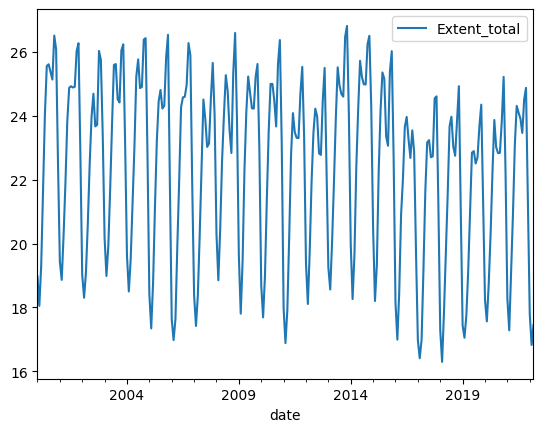

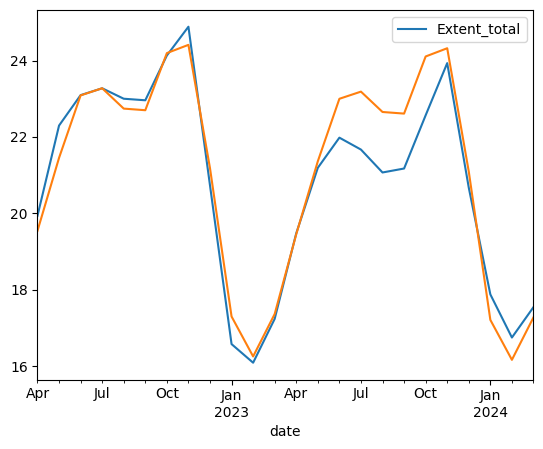

In [123]:
# create a cheeky plot
import matplotlib.pyplot as plt

train['2000':].plot()
test.plot()
y_pred.plot()
plt.show()

In [124]:
# create prediction for next 10 years
y_pred = fit_model.forecast(144)


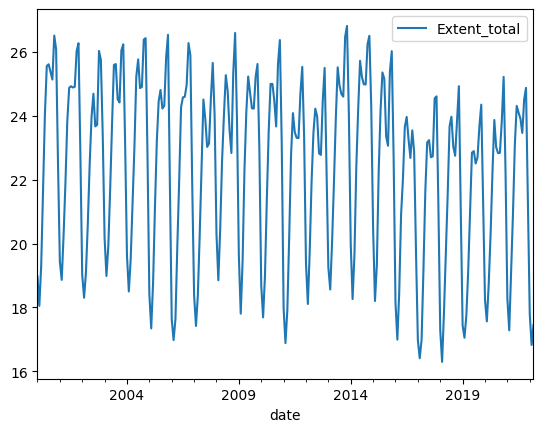

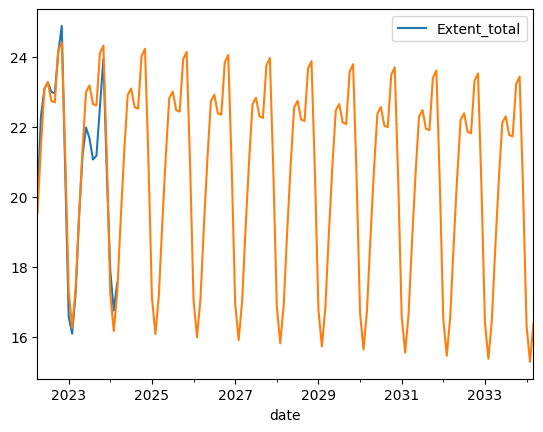

In [125]:
# show example model

train['2000':].plot()
test.plot()
y_pred.plot()
plt.show()

In [126]:
print(y_pred)

2022-04-30    19.541185
2022-05-31    21.450928
2022-06-30    23.086705
2022-07-31    23.274026
2022-08-31    22.741001
                ...    
2033-11-30    23.437168
2033-12-31    20.208318
2034-01-31    16.326265
2034-02-28    15.280149
2034-03-31    16.391685
Freq: M, Length: 144, dtype: float64


In [127]:
# turn prediction series object into dataframe
forecast_df = pd.DataFrame(y_pred)
forecast_df.reset_index(inplace=True)

# Label the index column and rename the other column
forecast_df.rename(columns={'index': 'date', 0:'prediction'}, inplace=True)

In [128]:
print(forecast_df)

          date  prediction
0   2022-04-30   19.541185
1   2022-05-31   21.450928
2   2022-06-30   23.086705
3   2022-07-31   23.274026
4   2022-08-31   22.741001
..         ...         ...
139 2033-11-30   23.437168
140 2033-12-31   20.208318
141 2034-01-31   16.326265
142 2034-02-28   15.280149
143 2034-03-31   16.391685

[144 rows x 2 columns]


In [129]:
# make 2D arrays so can compute linear regression
array_date = forecast_df['date'].values.reshape(-1, 1)
array_prediction = forecast_df['prediction'].values.reshape(-1,1)

In [130]:
# create linear regression w/ forecast
from sklearn.linear_model import LinearRegression

regression_model_total = LinearRegression()
regression_model_total.fit(array_date, array_prediction)
slope = regression_model_total.coef_[0][0]

# Print the slope
print("Slope:", slope)

Slope: -3.836613816415741e-18


In [ ]:
# that is a really really small number!
# though linear regression is obviously flawed,
# it seems as though sea ice will not hit zero any time soon